# Forecast para el Número de Colocaciones

Se cuentan con datos históricos de las colocaciones del Banco de la Nación desde el día 01/12/2020 hasta el 30/09/2025. Se tiene como variables tanto la cantidad de colocaciones otorgadas y el importe.

El objetivo del presente análisis es **estimar un modelo de Forecast que pueda pronosticar el volumen de colocaciones diarias** basado en datos históricos de comportamiento.

**Variables**:

- fecha: El día en el cual se realizaron las colocaciones
- num_colocaciones: La cantidad de colocaciones realizadas en dicha fecha
- mnt_colocaciones_soles: El importe total de las colocaciones realizadas, expresadas en Nuevos Soles

**Variable Objetivo**: num_colocaciones

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#=============== Análisis de Series Temporales =================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose

#=============== MLForecast =================================
from mlforecast import MLForecast
from mlforecast import MLForecast
from utilsforecast.plotting import plot_series
from mlforecast.utils import PredictionIntervals
from utilsforecast.preprocessing import fill_gaps
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

In [166]:
# Importaciones de librerías
df = pd.read_csv('colocaciones.csv',dtype=str,sep=";")
df.head()

,fecha,num_colocaciones,mnt_colocaciones_soles
0,01/12/2020,932,18693340.00
1,02/12/2020,951,17862718.00
2,03/12/2020,892,17174005.00
3,04/12/2020,788,15265139.00
4,05/12/2020,389,7803265.00


In [167]:
# Información de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765 entries, 0 to 1764
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   fecha                   1765 non-null   object
 1   num_colocaciones        1522 non-null   object
 2   mnt_colocaciones_soles  1522 non-null   object
dtypes: object(3)
memory usage: 41.5+ KB


In [168]:
# Realizar conversión de datos a fecha
df['fecha'] = pd.to_datetime(df['fecha'],format='%d/%m/%Y')

# Realizar conversión de datos a enteros
df['num_colocaciones'] = pd.to_numeric(df['num_colocaciones'], errors='coerce').astype('Int64')
df['mnt_colocaciones_soles'] = pd.to_numeric(df['mnt_colocaciones_soles'], errors='coerce').astype('Int64')

In [169]:
# Descripción estadística de los datos
df.describe()

,fecha,num_colocaciones,mnt_colocaciones_soles
count,1765,1522.0,1522.0
mean,2023-05-02 00:00:00,1070.260184,20613025.453351
min,2020-12-01 00:00:00,1.0,2300.0
25%,2022-02-15 00:00:00,767.25,14153529.0
50%,2023-05-02 00:00:00,1114.5,20165111.5
75%,2024-07-16 00:00:00,1388.75,27033210.5
max,2025-09-30 00:00:00,2719.0,65571387.0
std,NaN,462.484146,9992729.116777


In [170]:
# Coeficiente de Variación de num_colocaciones
(df['num_colocaciones'].std() / df['num_colocaciones'].mean()) * 100

43.21230974778597

In [171]:
# Coeficiente de Variación de mnt_colocaciones_soles
(df['mnt_colocaciones_soles'].std() / df['mnt_colocaciones_soles'].mean()) * 100

48.47774112243253

In [172]:
df['num_colocaciones'].isnull().sum()

243

In [173]:
df[df['num_colocaciones'].isnull()]

,fecha,num_colocaciones,mnt_colocaciones_soles
5,2020-12-06,<NA>,<NA>
7,2020-12-08,<NA>,<NA>
12,2020-12-13,<NA>,<NA>
19,2020-12-20,<NA>,<NA>
24,2020-12-25,<NA>,<NA>
...,...,...,...
1748,2025-09-14,<NA>,<NA>
1755,2025-09-21,<NA>,<NA>
1762,2025-09-28,<NA>,<NA>
1763,2025-09-29,<NA>,<NA>


**Conclusiones**:
- En un primer análisis, se puede ver que contamos con 1765 días en nuestro dataset, de los cuales contamos con información en 1522 días.
- Esto nos indica que tenemos 243 filas con datos faltantes.
- El coeficiente de variación para ambas variables es mayor al 30%, lo que indica que la media no es representativa.
- La mediana del número de colocaciones es de 1114.5 y


## 2. Análisis Exploratorio de Datos

In [174]:
# Rellenar los valores nulos como 0. Los datos nulos representan días en los que no hubo colocaciones
df['num_colocaciones'] = df['num_colocaciones'].fillna(0)
df['mnt_colocaciones_soles'] = df['mnt_colocaciones_soles'].fillna(0)

In [175]:
# Convertir la fecha en indice
df_index = df.set_index('fecha')

In [176]:
df_index.head()

,num_colocaciones,mnt_colocaciones_soles
fecha,,
2020-12-01,932,18693340
2020-12-02,951,17862718
2020-12-03,892,17174005
2020-12-04,788,15265139
2020-12-05,389,7803265


### 2.1. Análisis de la Variable Objetivo - num_colocaciones

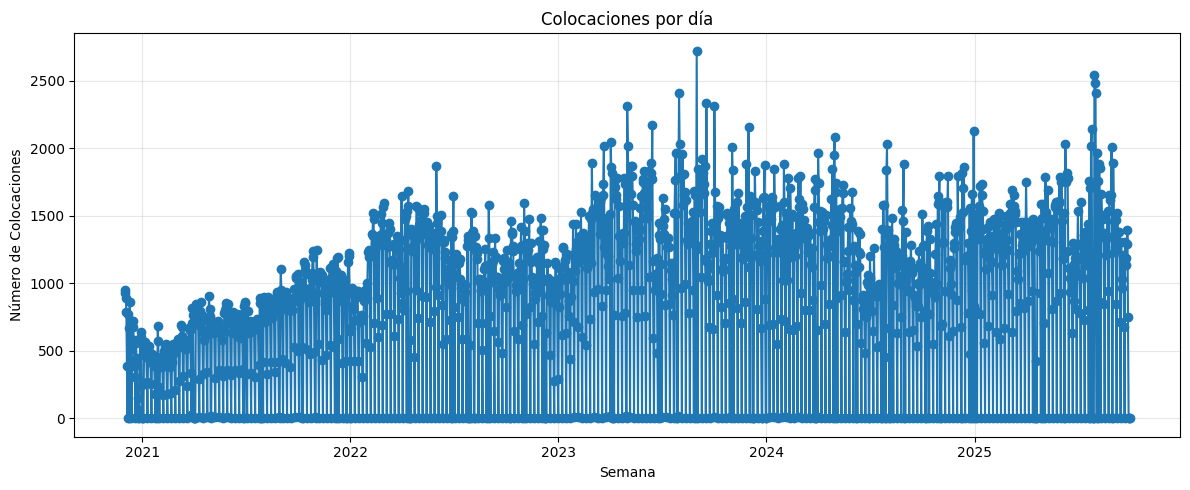

In [177]:
df_diario = df_index.resample(rule='D')['num_colocaciones'].sum()

plt.figure(figsize=(12,5))
plt.plot(df_diario.index, df_diario.values, marker='o')
plt.xlabel('Semana')
plt.ylabel('Número de Colocaciones')
plt.title('Colocaciones por día')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Resampleo por Semana

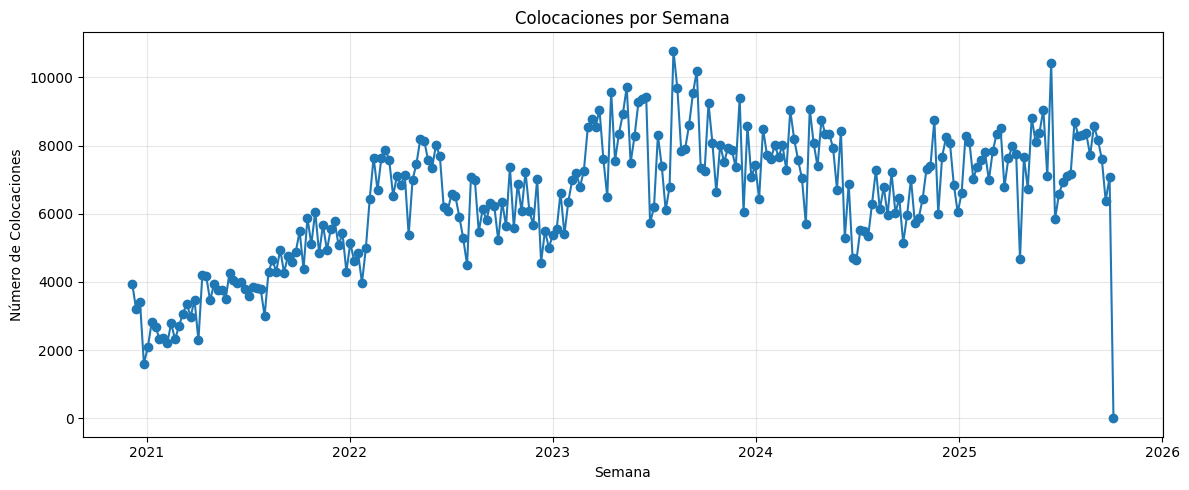

In [178]:
df_semanal = df_index.resample(rule='W')['num_colocaciones'].sum()

plt.figure(figsize=(12,5))
plt.plot(df_semanal.index, df_semanal.values, marker='o')
plt.xlabel('Semana')
plt.ylabel('Número de Colocaciones')
plt.title('Colocaciones por Semana')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Resampleo por Mes

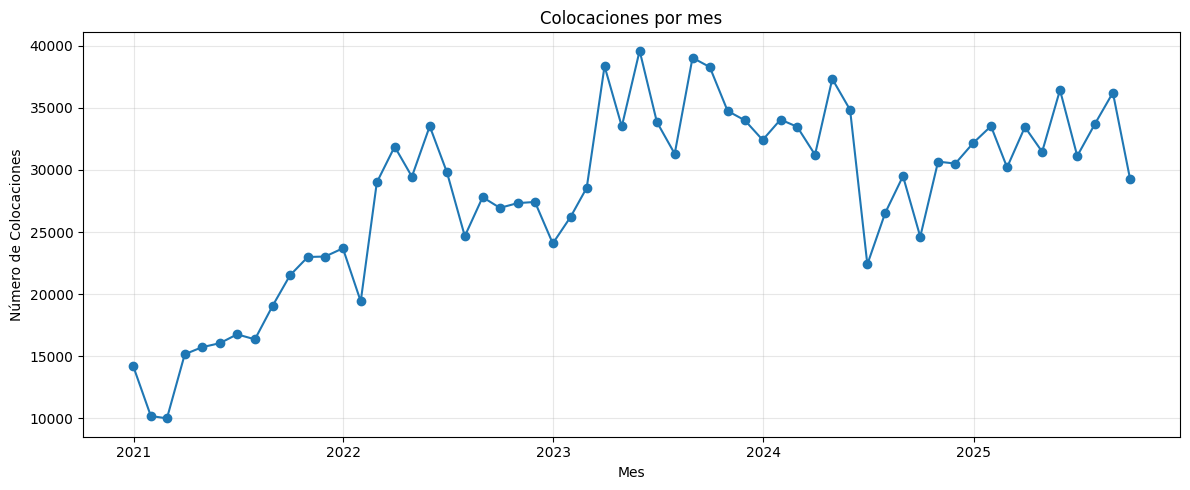

In [179]:
df_semanal = df_index.resample(rule='M')['num_colocaciones'].sum()

plt.figure(figsize=(12,5))
plt.plot(df_semanal.index, df_semanal.values, marker='o')
plt.xlabel('Mes')
plt.ylabel('Número de Colocaciones')
plt.title('Colocaciones por mes')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [180]:
fecha_inicial = df['fecha'].min()
fecha_final = df['fecha'].max()

print('Fecha Inicial:',fecha_inicial.date())
print('Fecha Final:',fecha_final.date())

Fecha Inicial: 2020-12-01
Fecha Final: 2025-09-30


**Hallazgo**
* En esta vista podemos identificar que durante el mes de diciembre 2020 hasta el mes de marzo 2022, hay una tendencia al alza bastante pronunciada. 
* Esto se puede explicar debido a la recuperación económica post pandemia.
* Se recomienda solo tomar en el análisis los datos a partir de marzo 2022, que es cuando la serie se estabiliza hacia adelante. Entrenar el modelo con estos datos incurriría en tomar fechas y comportamientos que, a día de hoy, ya no son representativos de la serie.
* Se recomienda, además, tomar años completos, por lo que el entrenamiento del modelo se realizará con datos de marzo 2022 hasta marzo 2025.
* Se tomarán los periodos de abril 2025 en adelante como un periodo OOT (Out of Time)

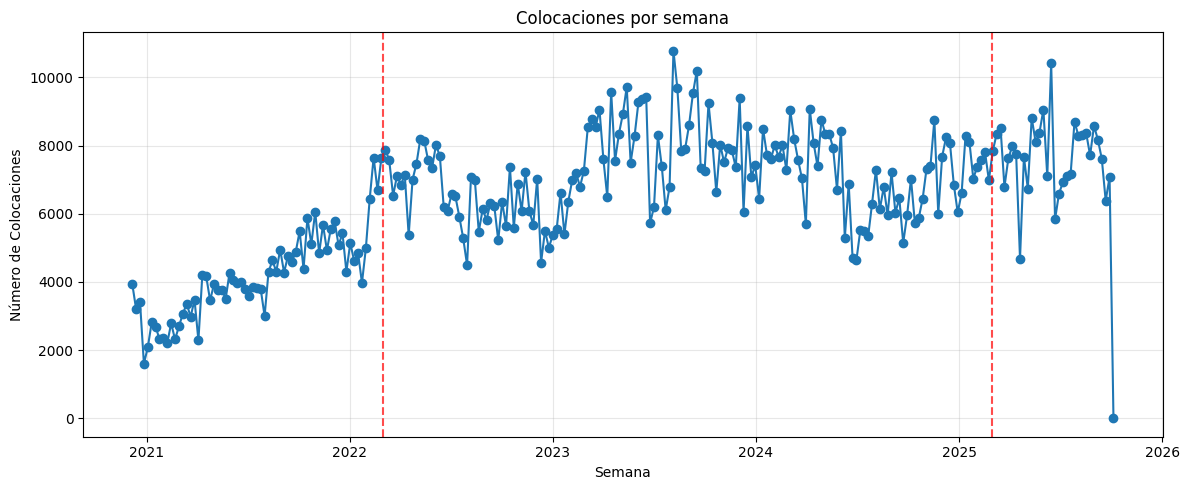

In [181]:
df_semanal = df_index.resample(rule='W')['num_colocaciones'].sum()

plt.figure(figsize=(12,5))
plt.plot(df_semanal.index, df_semanal.values, marker='o')
plt.axvline(x=pd.to_datetime('2022-03-01'), color='r', linestyle='--', alpha=0.7) # Linea inicial
plt.axvline(x=pd.to_datetime('2025-03-01'), color='r', linestyle='--', alpha=0.7) # Linea final
plt.xlabel('Semana')
plt.ylabel('Número de Colocaciones')
plt.title('Colocaciones por semana')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

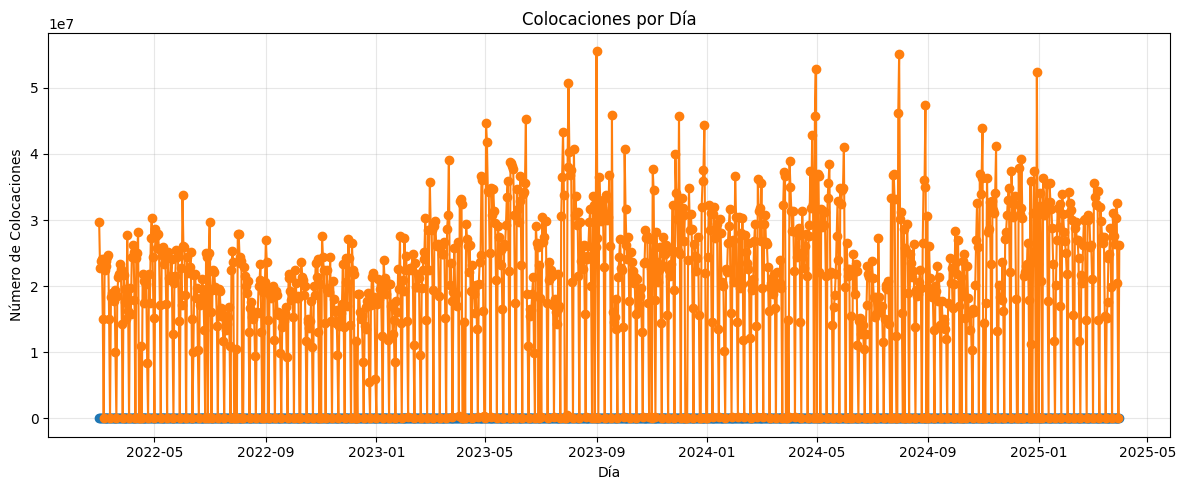

In [ ]:
# Ver la serie filtrada solo con las fechas definidas
df_filtrado = df_index[(df_index.index >= '2022-03-01' ) & (df_index.index <= '2025-03-31')]

plt.figure(figsize=(12,5))
plt.plot(df_filtrado.index, df_filtrado.values, marker='o')
plt.xlabel('Día')
plt.ylabel('Número de Colocaciones')
plt.title('Colocaciones por Día')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [237]:
df_filtrado['dia'] = df_filtrado.index.day
df_filtrado['mes'] = df_filtrado.index.month
df_filtrado['anio'] = df_filtrado.index.year
df_filtrado['dia_semana'] = df_filtrado.index.weekday

# Semana del año
df_filtrado["semana_anio"] = df_filtrado.index.isocalendar().week

# Semana del mes = semana_del_año - semana_del_año_primer_dia_mes + 1
df_filtrado["semana_mes"] = (
    df_filtrado["semana_anio"] - df_filtrado.index.to_period("M").to_timestamp().isocalendar().week.values + 1
)

Text(0, 0.5, 'Total de Colocaciones')

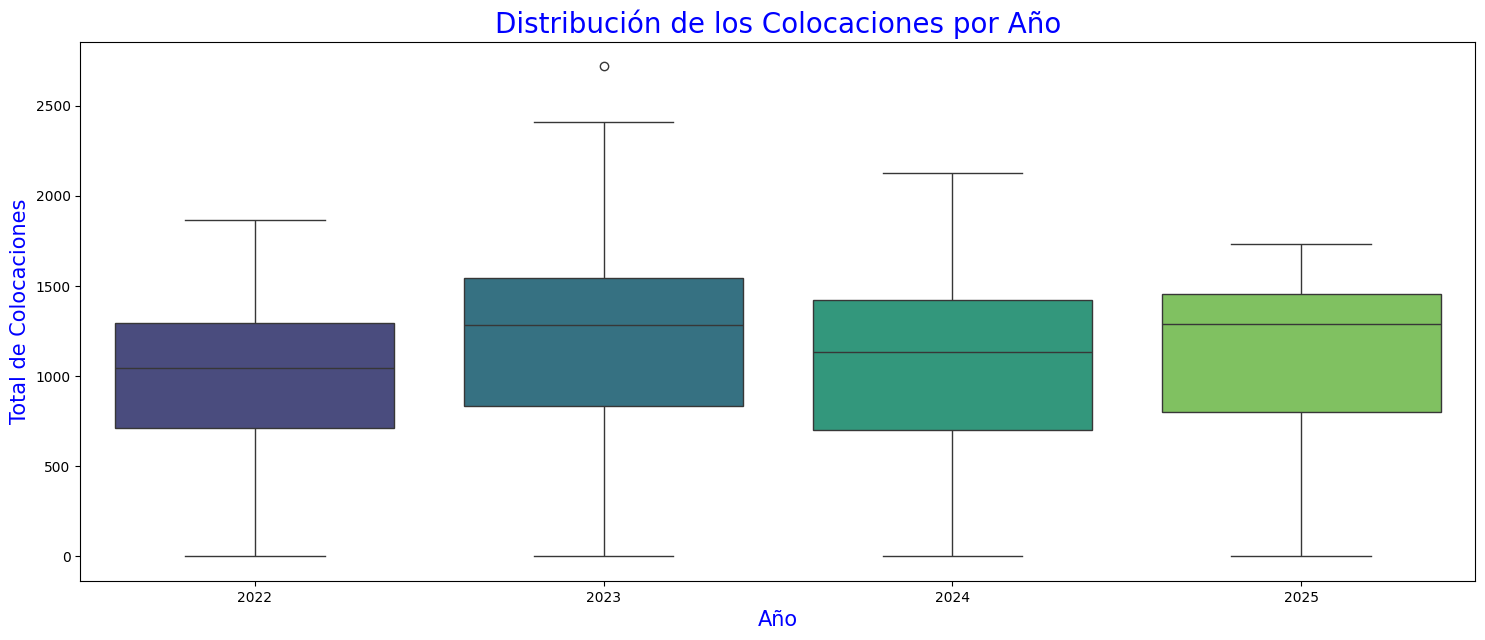

In [ ]:
f,ax = plt.subplots(figsize = (18,7))
sns.boxplot(x="anio", y="num_colocaciones",data=df_filtrado,palette="viridis")
plt.title("Distribución de los Colocaciones por Año",fontsize = 20,color='blue')
plt.xlabel('Año',fontsize = 15,color='blue')
plt.ylabel('Total de Colocaciones',fontsize = 15,color='blue')

**Hallazgo**
* No se ve una tendencia apreciable en cuanto a la evolución de las colocaciones en cuanto a los años.

Text(0, 0.5, 'Total de Colocaciones')

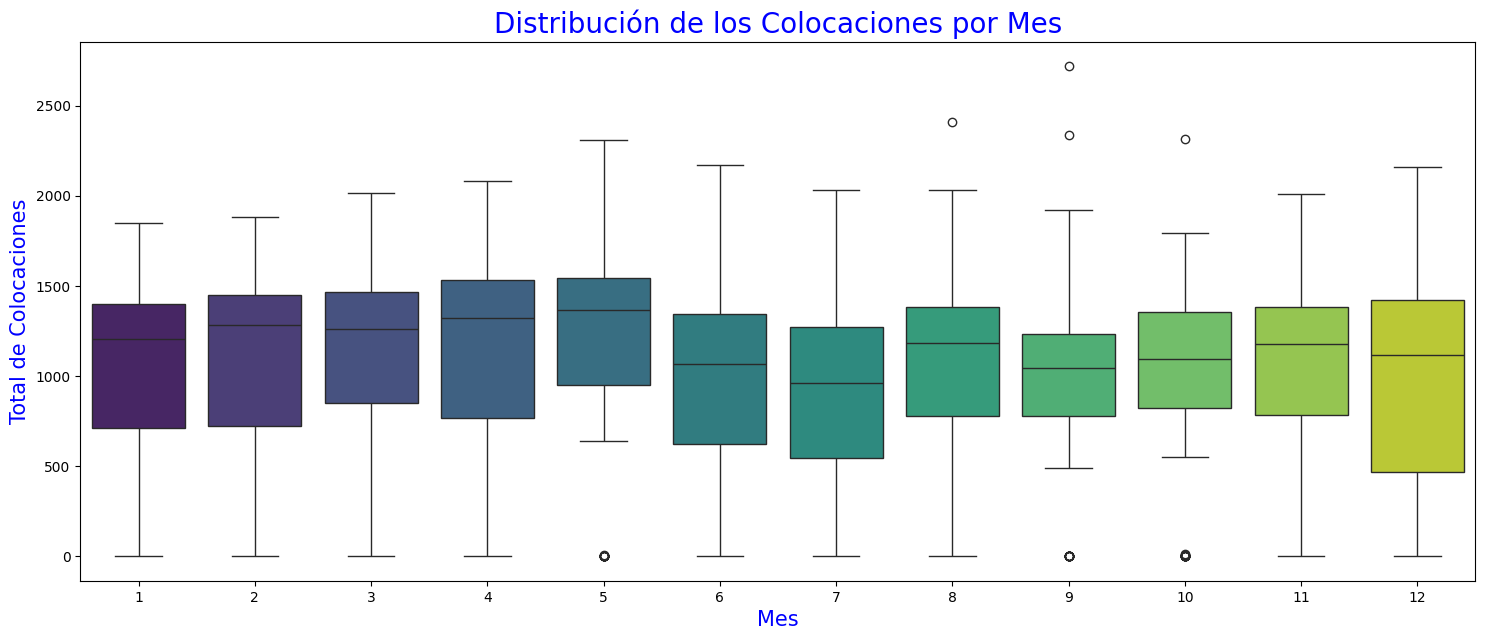

In [ ]:
f,ax = plt.subplots(figsize = (18,7))
sns.boxplot(x="mes", y="num_colocaciones",data=df_filtrado,palette="viridis")
plt.title("Distribución de los Colocaciones por Mes",fontsize = 20,color='blue')
plt.xlabel('Mes',fontsize = 15,color='blue')
plt.ylabel('Total de Colocaciones',fontsize = 15,color='blue')

**Hallazgo**
* El nivel general de las colocaciones suele ser bastante estable. Se aprecian ligeras tendencias en ciertos momentos del año, pero no una muy marcada.
* Se puede apreciar que el nivel de colocaciones es mayor durante los primeros meses del año
* Para los meses de junio-julio y diciembre se aprecian niveles más bajos de colocaciones, siendo estas fechas cercanas al pago de gratificaciones.
* Se registran valores extremos muy altos en los meses de agosto, setiembre y octubre.

Text(0, 0.5, 'Colocaciones')

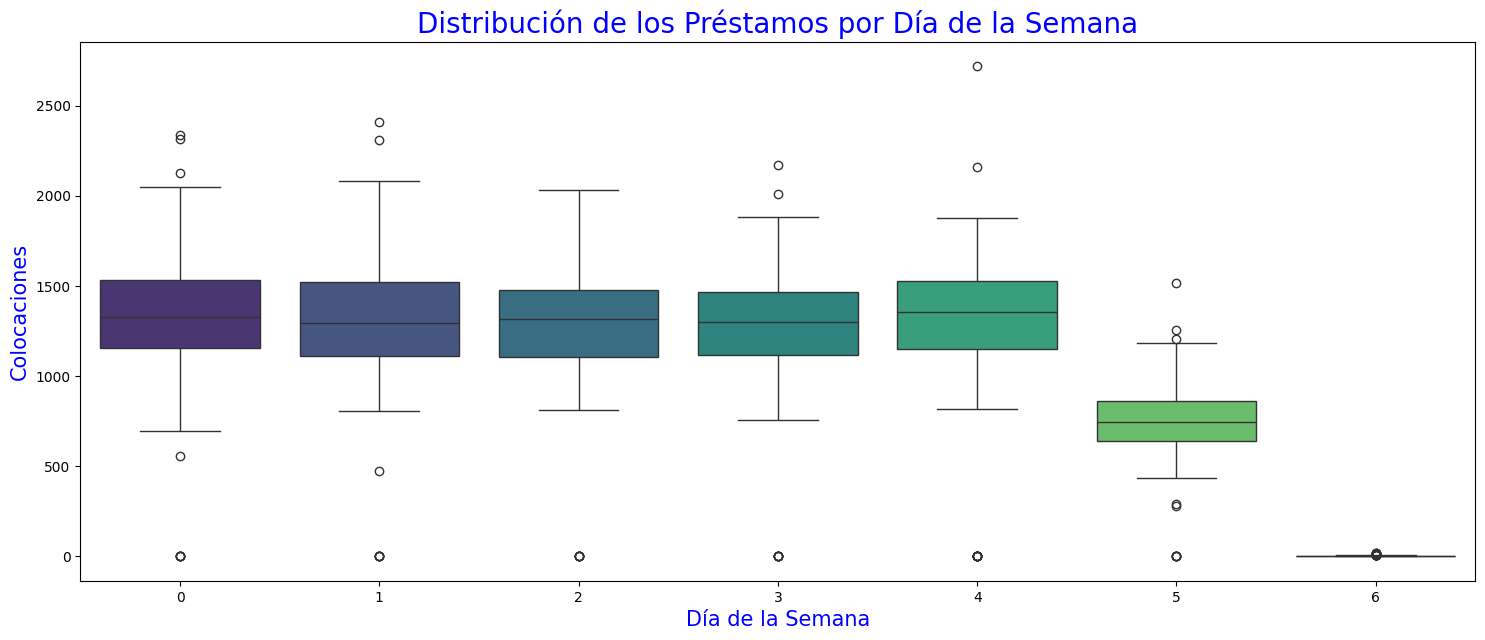

In [ ]:
f,ax = plt.subplots(figsize = (18,7))
sns.boxplot(x="dia_semana", y="num_colocaciones",data=df_filtrado,palette="viridis")
plt.title("Distribución de los Préstamos por Día de la Semana",fontsize = 20,color='blue')
plt.xlabel('Día de la Semana',fontsize = 15,color='blue')
plt.ylabel('Colocaciones',fontsize = 15,color='blue')

**Hallazgo**
* Durante los días de semana (lunes a viernes), la cantidad de colocaciones se muestra bastante estable.
* Los días sábados se ve una reducción en el volumen de colocaciones respecto a los demás días laborables. Esto se explica porque los días sábados las agencias del Banco de la Nación trabajan solo hasta el mediodía.
* Los días domingos no son laborables, sin embargo, se ve que hay domingos con colocaciones, lo cual debería responder o bien a un error de data o bien a una situación extraordinaria.

Text(0, 0.5, 'Total de Colocaciones')

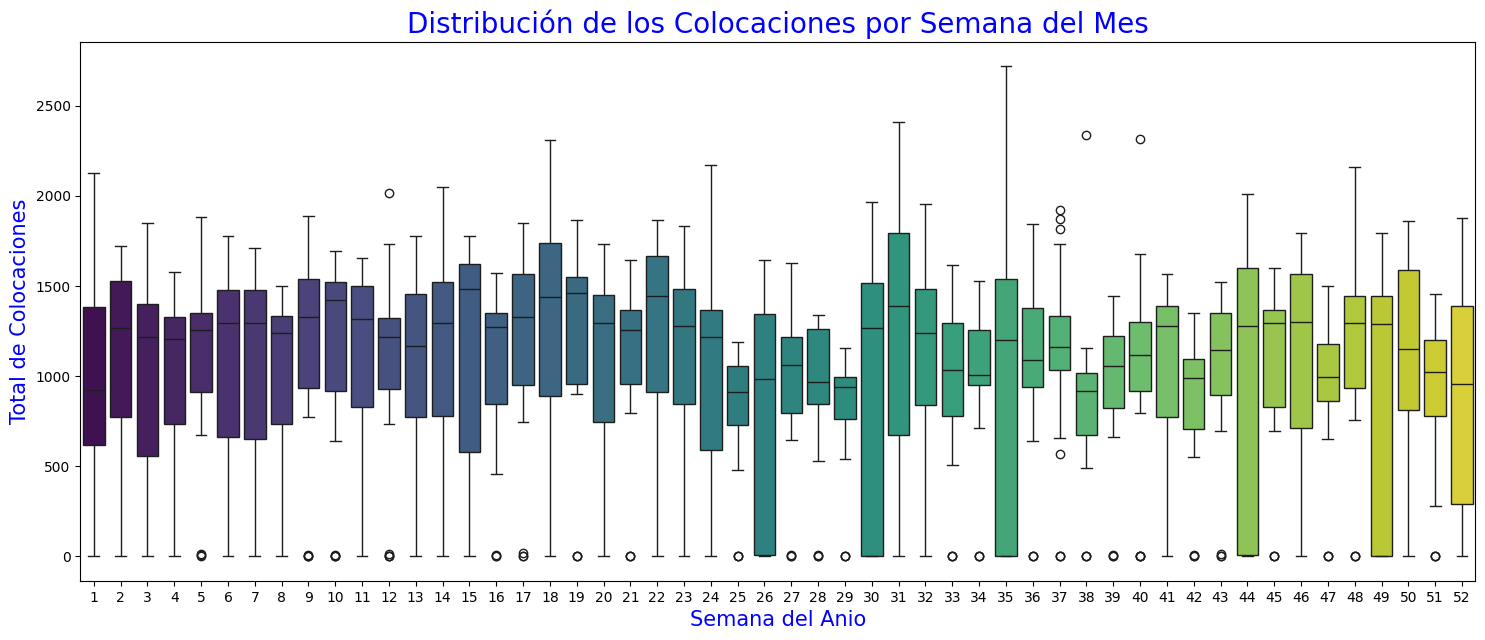

In [239]:
f,ax = plt.subplots(figsize = (18,7))
sns.boxplot(x="semana_anio", y="num_colocaciones",data=df_filtrado,palette="viridis")
plt.title("Distribución de los Colocaciones por Semana del Mes",fontsize = 20,color='blue')
plt.xlabel('Semana del Anio',fontsize = 15,color='blue')
plt.ylabel('Total de Colocaciones',fontsize = 15,color='blue')

Text(0, 0.5, 'Número de Colocaciones')

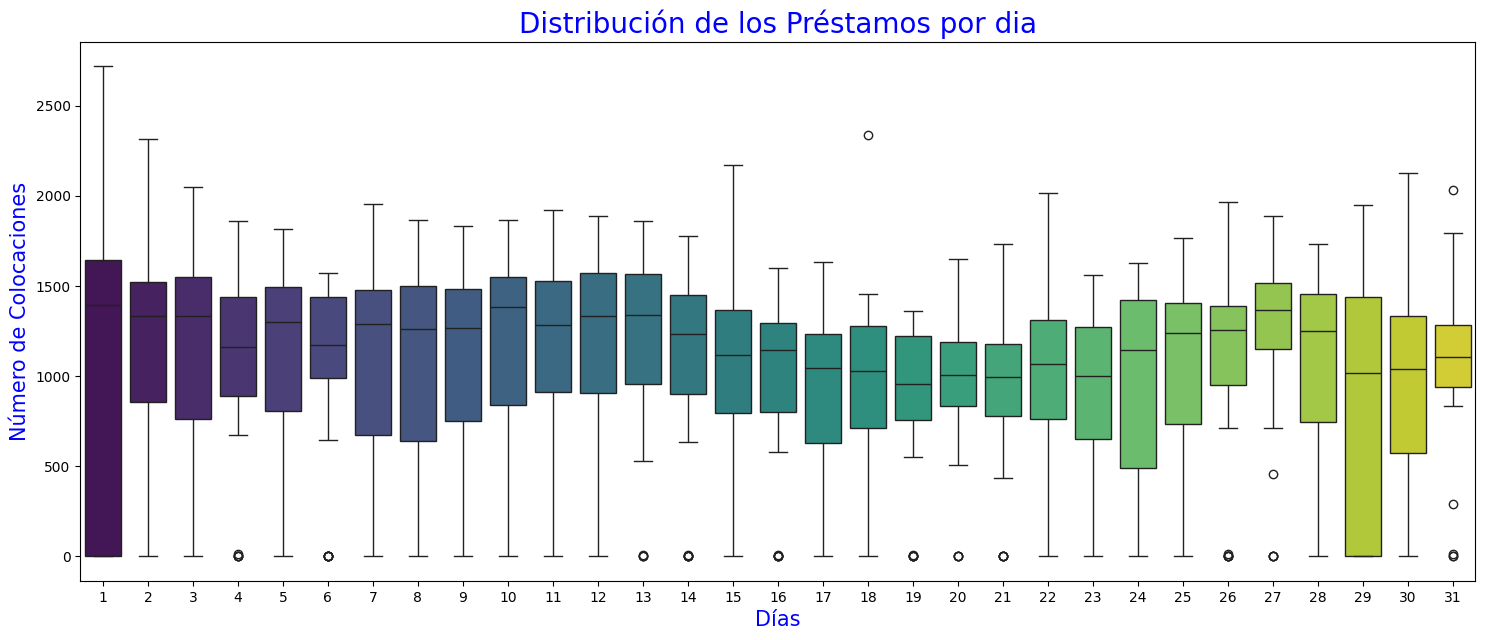

In [186]:
f,ax = plt.subplots(figsize = (18,7))
sns.boxplot(x="dia", y="num_colocaciones",data=df_filtrado,palette="viridis")
plt.title("Distribución de los Préstamos por dia",fontsize = 20,color='blue')
plt.xlabel('Días',fontsize = 15,color='blue')
plt.ylabel('Número de Colocaciones',fontsize = 15,color='blue')

**Hallazgos**
* En este gráfica se puede ver que hasta los días 13-14, las colocaciones son ligeramente mayores a la segunda parte del mes.
* En la tercera semana del mes (entre los días 15 al 23, aproximadamente) hay un decremento en cuanto a la media de colocaciones, y esta se vuelve a elevar para la última semana del mes.
* Esto puede explicarse por las fechas de pago que se pueden dar a partir de la segunda parte del mes, por lo que no requieren de un préstamo en un momento de liquidez.

In [242]:
# Quitamos los días domingos de la serie, para evitar ruidos en la serie temporal
df_sin_domingos = df_filtrado[df_filtrado.index.dayofweek != 6]  # 6 = domingo

**Test de Estacionariedad (ADF)**

In [244]:
resultado_adf = adfuller(df_sin_domingos['num_colocaciones'])

# Extraer estadísticas
estadistico_adf = resultado_adf[0]
p_valor = resultado_adf[1]

# Imprimir resultados
print(f"Estadístico ADF: {estadistico_adf:.4f}")
print(f"Valor-p: {p_valor:.4f}\n")

# Interpretación
if p_valor < 0.05:
    print("✅ El valor-p es menor a 0.05. Rechazamos la hipótesis nula.")
    print("Conclusión: La serie es estacionaria (no tiene raíz unitaria).")
else:
    print("❌ El valor-p es mayor a 0.05. No rechazamos la hipótesis nula.")
    print("Conclusión: La serie no es estacionaria (tiene raíz unitaria).")

Estadístico ADF: -3.6932
Valor-p: 0.0042

✅ El valor-p es menor a 0.05. Rechazamos la hipótesis nula.
Conclusión: La serie es estacionaria (no tiene raíz unitaria).


**Decomposición Estacional**

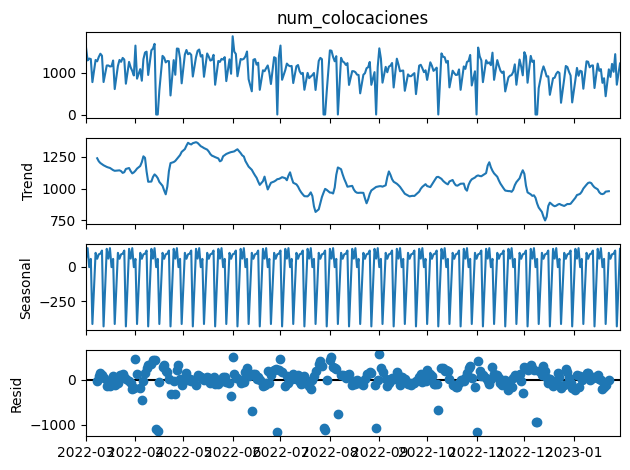

In [245]:
result = seasonal_decompose(df_sin_domingos['num_colocaciones'][:24*12], model='additive', period=12)

result.plot()
plt.show()

**Análisis de Autocorrelación y Autocorrelación Parcial**

<Figure size 1700x500 with 0 Axes>

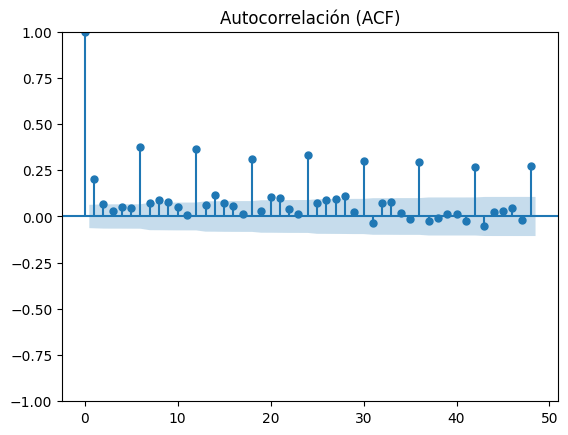

In [248]:
# Graficar la autocorrelación (ACF)
plt.figure(figsize=(17,5))
plot_acf(df_sin_domingos['num_colocaciones'], lags=48) 
plt.title('Autocorrelación (ACF)')
plt.show()

**Hallazgo**
* En el gráfico de autocorrelación se puede apreciar que casi todos los lags son significativos.
* También se aprecia que el nivel de autocorrelación de lags se repite cada cierto tiempo, lo que habla de posible estacionalidad.

<Figure size 1700x500 with 0 Axes>

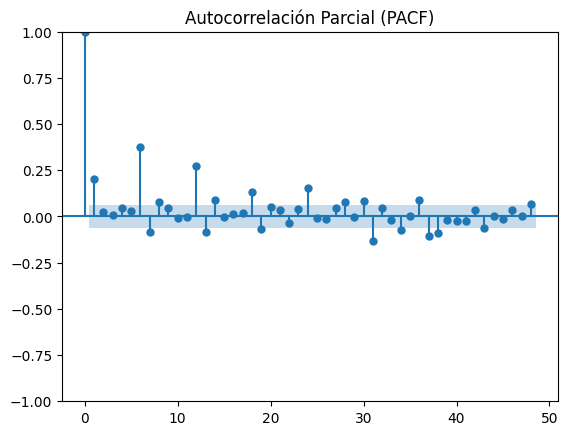

In [250]:
# Graficar la autocorrelación (ACF)
plt.figure(figsize=(17,5))
plot_pacf(df_sin_domingos['num_colocaciones'], lags=48) # Se toma 12 para ver estacionalidad anual
plt.title('Autocorrelación Parcial (PACF)')
plt.show()

**Hallazgo**
* En esta gráfica se ve 

# 3. Entrenamiento de Modelo

In [341]:
train = df_filtrado.reset_index()

# Asegúrate de que esté ordenada
train = train.sort_values('fecha')

# Crear rango completo esperado (de primer a último día)
full_range = pd.date_range(train['fecha'].min(), train['fecha'].max(), freq='D')

# Detectar cuáles fechas faltan
fechas_faltantes = full_range.difference(train['fecha'])

print(f"Total de días faltantes: {len(fechas_faltantes)}")
fechas_faltantes[:20]  # muestra los primeros 20

Total de días faltantes: 0


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [342]:
df_filtrado.reset_index().head(5)

,fecha,num_colocaciones,mnt_colocaciones_soles,dia,mes,anio,dia_semana,semana_anio,semana_mes
0,2022-03-01,1594,29672846,1,3,2022,1,9,1
1,2022-03-02,1291,22693644,2,3,2022,2,9,1
2,2022-03-03,1335,23802897,3,3,2022,3,9,1
3,2022-03-04,1323,24086858,4,3,2022,4,9,1
4,2022-03-05,773,15013874,5,3,2022,5,9,1


In [346]:
train = df_filtrado.reset_index()[['fecha','num_colocaciones']]

In [347]:
train

,fecha,num_colocaciones
0,2022-03-01,1594
1,2022-03-02,1291
2,2022-03-03,1335
3,2022-03-04,1323
4,2022-03-05,773
...,...,...
1122,2025-03-27,1370
1123,2025-03-28,1457
1124,2025-03-29,814
1125,2025-03-30,0


In [348]:
# recupera la columna 'fecha'
train = train.rename(columns={
    'fecha': 'ds',
    'num_colocaciones': 'y'
})
train['unique_id'] = 'serie_1'

train

,ds,y,unique_id
0,2022-03-01,1594,serie_1
1,2022-03-02,1291,serie_1
2,2022-03-03,1335,serie_1
3,2022-03-04,1323,serie_1
4,2022-03-05,773,serie_1
...,...,...,...
1122,2025-03-27,1370,serie_1
1123,2025-03-28,1457,serie_1
1124,2025-03-29,814,serie_1
1125,2025-03-30,0,serie_1


In [284]:
# Create a list of models and instantiation parameters
models = [
    RandomForestRegressor(n_estimators=500, max_depth=5),
    DecisionTreeRegressor(max_depth=5),
    KNeighborsRegressor(n_neighbors=5),
    XGBRegressor(estimators=100)
    ]

In [349]:
#from pandas.tseries.offsets import CustomBusinessDay

#mon_to_sat = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri Sat')

mlf = MLForecast(models=models,
                   freq='D',
                   lags=[1,2,3,4,5,6,7],
                   lag_transforms={
                       1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                   },
                   target_transforms=[Differences([1])],
                   date_features=['year', 'month','day','dayofweek'],
                   num_threads=6)

In [350]:
mlf.models

{'RandomForestRegressor': RandomForestRegressor(max_depth=5, n_estimators=500),
 'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=5),
 'KNeighborsRegressor': KNeighborsRegressor(),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, estimators=100, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)}

In [351]:
prep = mlf.preprocess(train,static_features=[])
prep

,ds,y,unique_id,lag1,lag2,lag3,lag4,lag5,lag6,lag7,rolling_mean_lag1_window_size4,rolling_min_lag1_window_size4,rolling_max_lag1_window_size4,year,month,day,dayofweek
8,2022-03-09,104.0,serie_1,-32.0,1301.0,-773.0,-550.0,-12.0,44.0,-303.0,-13.50,-773.0,1301.0,2022,3,9,2
9,2022-03-10,77.0,serie_1,104.0,-32.0,1301.0,-773.0,-550.0,-12.0,44.0,150.00,-773.0,1301.0,2022,3,10,3
10,2022-03-11,-48.0,serie_1,77.0,104.0,-32.0,1301.0,-773.0,-550.0,-12.0,362.50,-32.0,1301.0,2022,3,11,4
11,2022-03-12,-627.0,serie_1,-48.0,77.0,104.0,-32.0,1301.0,-773.0,-550.0,25.25,-48.0,104.0,2022,3,12,5
12,2022-03-13,-775.0,serie_1,-627.0,-48.0,77.0,104.0,-32.0,1301.0,-773.0,-123.50,-627.0,104.0,2022,3,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,2025-03-27,130.0,serie_1,-45.0,-170.0,1455.0,-856.0,-509.0,148.0,-4.0,96.00,-856.0,1455.0,2025,3,27,3
1123,2025-03-28,87.0,serie_1,130.0,-45.0,-170.0,1455.0,-856.0,-509.0,148.0,342.50,-170.0,1455.0,2025,3,28,4
1124,2025-03-29,-643.0,serie_1,87.0,130.0,-45.0,-170.0,1455.0,-856.0,-509.0,0.50,-170.0,130.0,2025,3,29,5
1125,2025-03-30,-814.0,serie_1,-643.0,87.0,130.0,-45.0,-170.0,1455.0,-856.0,-117.75,-643.0,130.0,2025,3,30,6


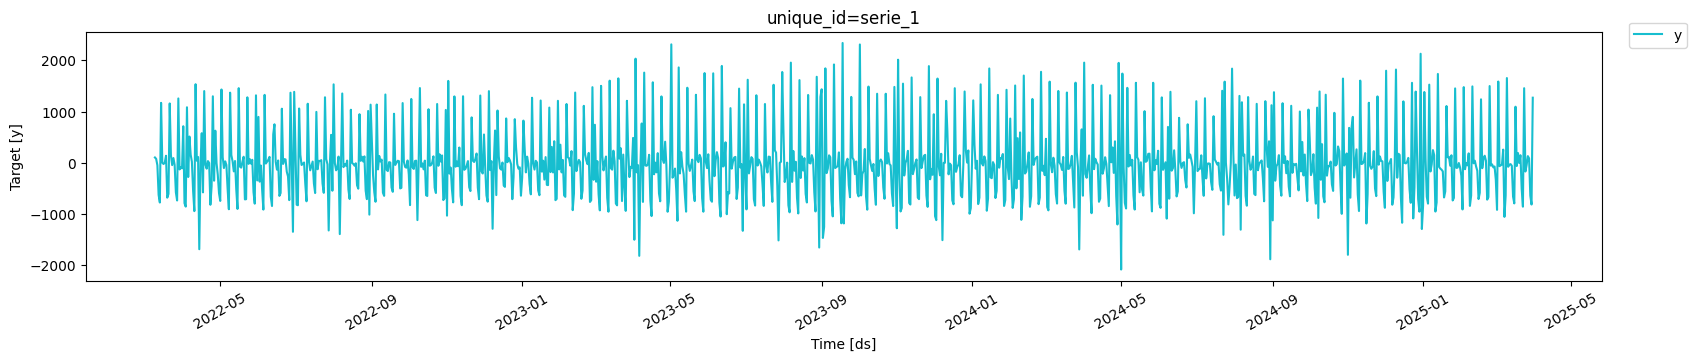

In [352]:
plot_series(prep)

In [353]:
mlf.fit(
    df=train,  # solo columnas esenciales
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[],
    fitted=True
)

MLForecast(models=[RandomForestRegressor, DecisionTreeRegressor, KNeighborsRegressor, XGBRegressor], freq=D, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'rolling_mean_lag1_window_size4', 'rolling_min_lag1_window_size4', 'rolling_max_lag1_window_size4'], date_features=['year', 'month', 'day', 'dayofweek'], num_threads=6)

In [354]:
cv_result = mlf.cross_validation(
    df=train[['unique_id', 'ds', 'y']],
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[],
    n_windows=2,
    h=6
)

In [355]:
cv_result

,unique_id,ds,cutoff,y,RandomForestRegressor,DecisionTreeRegressor,KNeighborsRegressor,XGBRegressor
0,serie_1,2025-03-20,2025-03-19,1217,1178.264771,1187.828369,1228.199951,1196.136963
1,serie_1,2025-03-21,2025-03-19,1365,1156.064819,1154.656738,1304.199951,1303.247803
2,serie_1,2025-03-22,2025-03-19,856,481.723999,542.933228,693.999939,618.882507
3,serie_1,2025-03-23,2025-03-19,0,-238.811829,-68.790283,-30.000061,-59.421326
4,serie_1,2025-03-24,2025-03-19,1455,1064.215820,1089.965820,1198.199951,1195.831787
5,serie_1,2025-03-25,2025-03-19,1285,1018.942505,1056.794189,1151.799927,1208.934570
6,serie_1,2025-03-26,2025-03-25,1240,1251.077271,1251.950195,979.799988,1228.173218
7,serie_1,2025-03-27,2025-03-25,1370,1218.651855,1218.900391,1127.199951,1328.309448
8,serie_1,2025-03-28,2025-03-25,1457,1165.809692,1185.850586,1214.599976,1553.742188
9,serie_1,2025-03-29,2025-03-25,814,563.141846,573.304077,628.599976,811.845093


In [356]:
from utilsforecast.losses import mse, mae, rmse, mape, smape

def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

In [358]:

evaluation_df = evaluate_cv(cv_result, rmse)
evaluation_df.T

,0
unique_id,serie_1
RandomForestRegressor,238.903698
DecisionTreeRegressor,219.827843
KNeighborsRegressor,195.210504
XGBRegressor,124.844908
best_model,XGBRegressor


In [331]:
# Luego, al predecir:
forecast = mlf.predict(h=18)
forecast = forecast[forecast['ds'].dt.dayofweek != 6]  # quita domingos

In [ ]:
from xgboost import XGBRegressor
import optuna
from mlforecast.target_transforms import LocalRobustScaler, LocalStandardScaler

def objective(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'max_leaves': trial.suggest_int('max_leaves', 8, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2500),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),
        'subsample': trial.suggest_float('subsample', 0.3, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.01, 0.5),
        "random_state" : trial.suggest_categorical('random_state', [42]),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror']),
        "n_jobs" : trial.suggest_categorical('n_jobs', [-1]),
    }

    # Agregar los paramentros
    model_xgb = [XGBRegressor(**params)]

    model = MLForecast(models = model_xgb,
                 freq='MS', 
                 lags=[1,7],
                 target_transforms=[ LocalStandardScaler()],
                 date_features=["year", "month", "day"],
                 num_threads=4
                 ) 
    # fit model
    model.fit(train,fitted=True, static_features= [], 
        prediction_intervals=PredictionIntervals(n_windows=3, h= 6, method="conformal_distribution") )

    p = model.predict(h = 6)
    p = p.merge(test[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

    error = mean_absolute_percentage_error(p['y'], p['XGBRegressor'])
    
    return error

# Optimización de Hiperparámetros

In [359]:
import optuna

from sklearn.metrics import mean_absolute_percentage_error

In [332]:
forecast

,unique_id,ds,RandomForestRegressor,DecisionTreeRegressor,KNeighborsRegressor,XGBRegressor
0,serie_1,2025-04-01,1285.507690,1237.397705,1167.800049,1392.439087
1,serie_1,2025-04-02,1257.406372,1204.795410,1140.600098,1162.234619
2,serie_1,2025-04-03,1230.086548,1172.193115,1133.400146,1198.643799
3,serie_1,2025-04-04,1206.413818,1139.590820,1332.200195,1318.426636
4,serie_1,2025-04-05,595.550598,526.868286,741.200195,745.713745
5,serie_1,2025-04-07,1700.636230,1685.624390,-20.599792,1568.463623
6,serie_1,2025-04-08,1649.855469,1653.022095,1302.200195,1454.057861
7,serie_1,2025-04-09,1622.198975,1620.419800,1144.000244,1488.978149
8,serie_1,2025-04-10,1594.502686,1587.817505,1076.400269,1509.172729
9,serie_1,2025-04-11,1570.531372,1555.215210,1202.600220,1487.649414


In [333]:
from utilsforecast.losses import mse, mae, rmse, mape, smape

def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

In [334]:
cv_result = mlf.cross_validation(
    df=train[['unique_id', 'ds', 'y']],  # solo columnas esenciales
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[],   # importante: vacío
    n_windows=2,
    h=5
)

cv_result

ValueError: Cross validation result produced less results than expected. Please verify that the frequency set on the MLForecast constructor matches your series' and that there aren't any missing periods.

In [ ]:
#    prediction_intervals=PredictionIntervals(
#        n_windows=3,
#        h=5,
#        method='conformal_distribution'
#    )

In [ ]:
df[['num_colocaciones','mnt_colocaciones_soles']].corr()

,num_colocaciones,mnt_colocaciones_soles
num_colocaciones,1.000000,0.968608
mnt_colocaciones_soles,0.968608,1.000000


In [190]:
import numpy as np

In [193]:
df_filtrado['num_colocaciones'].isnull().sum()

0

In [198]:
y = df_filtrado['num_colocaciones'].astype(float)

In [197]:
df_filtrado['num_colocaciones'].astype(float)

fecha
2022-03-01    1594.0
2022-03-02    1291.0
2022-03-03    1335.0
2022-03-04    1323.0
2022-03-05     773.0
               ...  
2025-03-27    1370.0
2025-03-28    1457.0
2025-03-29     814.0
2025-03-30       0.0
2025-03-31    1270.0
Name: num_colocaciones, Length: 1127, dtype: float64

In [202]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

y = df_filtrado['num_colocaciones']

modelo_sarima = auto_arima(
    y,
    seasonal=True,
    m=7,           # ajusta s = número de períodos (aquí 12 si es mensual)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=18027.401, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17062.511, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=18025.401, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17940.648, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=16829.896, Time=1.08 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=16973.843, Time=0.54 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=16729.671, Time=1.54 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=16946.034, Time=0.70 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=16687.666, Ti

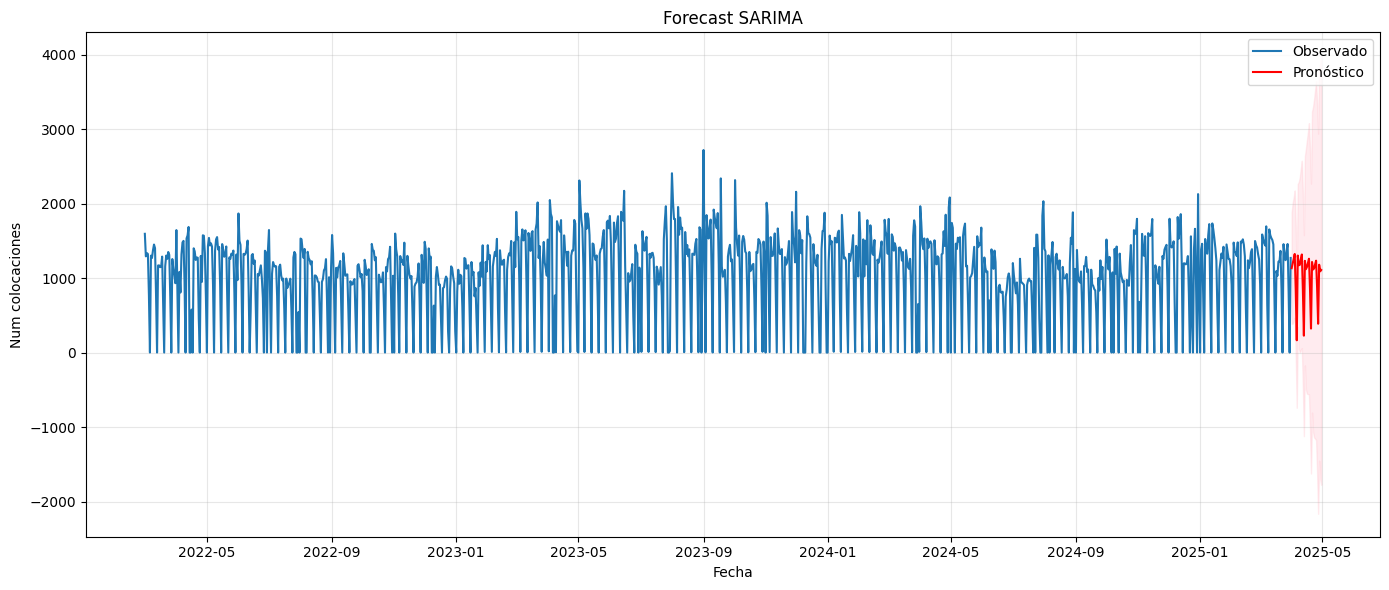

In [212]:
n_periods = 30
forecast, conf_int = modelo_sarima.predict(n_periods=n_periods, return_conf_int=True)

# Índice de tiempo para forecast (continuación de y.index)
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1),
                               periods=n_periods, freq="D")

# Graficamos histórico + forecast
plt.figure(figsize=(14,6))
plt.plot(y.index, y, label='Observado')
plt.plot(forecast_index, forecast, label='Pronóstico', color='red')

# Bandas de confianza
plt.fill_between(forecast_index,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='pink', alpha=0.3)

plt.title('Forecast SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Num colocaciones')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

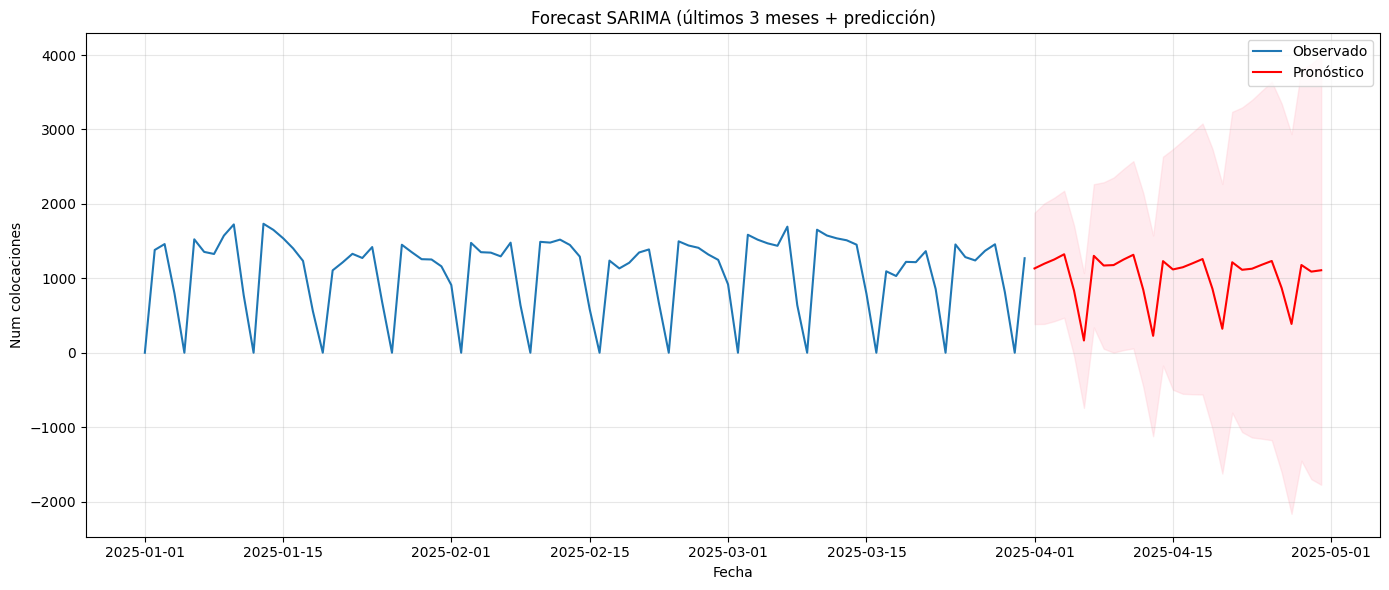

In [213]:
import matplotlib.pyplot as plt

n_periods = 30
forecast, conf_int = modelo_sarima.predict(n_periods=n_periods, return_conf_int=True)

# Índice de tiempo para forecast
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1),
                               periods=n_periods, freq="D")

# Concatenamos histórico + forecast para graficar ventana reducida
hist_last = y.last("90D")   # últimos 90 días

plt.figure(figsize=(14,6))
plt.plot(hist_last.index, hist_last, label="Observado")

plt.plot(forecast_index, forecast, label="Pronóstico", color="red")

plt.fill_between(forecast_index,
                 conf_int[:,0],
                 conf_int[:,1],
                 color="pink", alpha=0.3)

plt.title("Forecast SARIMA (últimos 3 meses + predicción)")
plt.xlabel("Fecha")
plt.ylabel("Num colocaciones")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


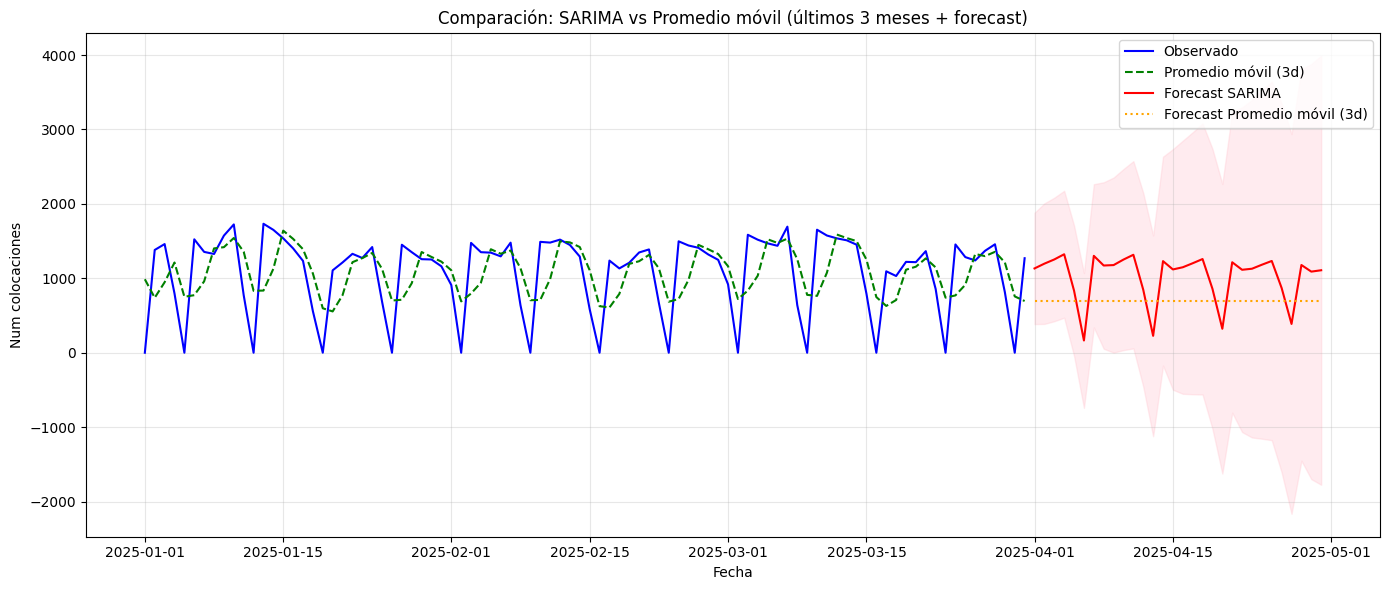

In [219]:
n_periods = 30
forecast, conf_int = modelo_sarima.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1),
                               periods=n_periods, freq="D")

# =========================
# Rolling mean histórico
# =========================
window = 3
rolling_mean = y.rolling(window=window).mean()

# Último valor del promedio móvil (baseline para forecast)
last_rm = rolling_mean.iloc[-1]
rolling_forecast = np.full(shape=n_periods, fill_value=last_rm)

# =========================
# Plot comparativo
# =========================
hist_last = y.last("90D")   # últimos 3 meses

plt.figure(figsize=(14,6))

# Observado
plt.plot(hist_last.index, hist_last, label="Observado", color="blue")

# Promedio móvil histórico
plt.plot(rolling_mean.last("90D").index, rolling_mean.last("90D"),
         label=f"Promedio móvil ({window}d)", color="green", linestyle="--")

# Forecast SARIMA
plt.plot(forecast_index, forecast, label="Forecast SARIMA", color="red")

# Forecast promedio móvil extendido
plt.plot(forecast_index, rolling_forecast,
         label=f"Forecast Promedio móvil ({window}d)", color="orange", linestyle=":")

# Intervalo de confianza SARIMA
plt.fill_between(forecast_index,
                 conf_int[:,0],
                 conf_int[:,1],
                 color="pink", alpha=0.3)

plt.title("Comparación: SARIMA vs Promedio móvil (últimos 3 meses + forecast)")
plt.xlabel("Fecha")
plt.ylabel("Num colocaciones")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [229]:
# Crear DataFrame con forecast y bandas de confianza
forecast_df = pd.DataFrame({
    "Fecha": forecast_index,
    "Forecast_SARIMA": forecast,
    "Lower_CI": conf_int[:, 0],
    "Upper_CI": conf_int[:, 1]
})

# Mostrar primeros registros
print(forecast_df.head())

# Opcional: mostrar como tabla bonita en Jupyter
from IPython.display import display

meta = 18000

forecast_df['meta'] = (forecast_df['Forecast_SARIMA'].astype(float) / meta).astype(float).round(3) * 100
forecast_df["meta_acumulada"] = forecast_df["meta"].cumsum()

# Añadir meta acumulada

display(forecast_df)

                Fecha  Forecast_SARIMA    Lower_CI     Upper_CI
2025-04-01 2025-04-01      1132.739618  384.866318  1880.612918
2025-04-02 2025-04-02      1197.003649  387.220136  2006.787163
2025-04-03 2025-04-03      1253.268421  423.443772  2083.093071
2025-04-04 2025-04-04      1323.215483  470.505870  2175.925097
2025-04-05 2025-04-05       833.629418  -41.346254  1708.605091


,Fecha,Forecast_SARIMA,Lower_CI,Upper_CI,meta,meta_acumulada
2025-04-01,2025-04-01,1132.739618,384.866318,1880.612918,6.3,6.3
2025-04-02,2025-04-02,1197.003649,387.220136,2006.787163,6.7,13.0
2025-04-03,2025-04-03,1253.268421,423.443772,2083.093071,7.0,20.0
2025-04-04,2025-04-04,1323.215483,470.505870,2175.925097,7.4,27.4
2025-04-05,2025-04-05,833.629418,-41.346254,1708.605091,4.6,32.0
2025-04-06,2025-04-06,164.671355,-741.393076,1070.735786,0.9,32.9
2025-04-07,2025-04-07,1301.953726,339.676363,2264.231088,7.2,40.1
2025-04-08,2025-04-08,1171.988161,53.519493,2290.456829,6.5,46.6
2025-04-09,2025-04-09,1177.778902,1.908471,2353.649334,6.5,53.1
2025-04-10,2025-04-10,1251.735426,35.248077,2468.222776,7.0,60.1


In [220]:
from sklearn.metrics import mean_squared_error

# =========================
# Split train/test
# =========================
n_test = 30
train, test = y[:-n_test], y[-n_test:]

# Predicciones SARIMA sobre test
sarima_forecast = modelo_sarima.predict(n_periods=n_test)

# Baseline: último promedio móvil (30d) proyectado constante
window = 30
rolling_mean = train.rolling(window=window).mean()
last_rm = rolling_mean.iloc[-1]
rm_forecast = np.full(shape=n_test, fill_value=last_rm)

# =========================
# Calcular RMSE
# =========================
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))
rmse_rm = np.sqrt(mean_squared_error(test, rm_forecast))

print(f"RMSE SARIMA: {rmse_sarima:.2f}")
print(f"RMSE Promedio Móvil: {rmse_rm:.2f}")

RMSE SARIMA: 713.94
RMSE Promedio Móvil: 548.80


In [206]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_arch
from pmdarima import auto_arima
from arch import arch_model

In [221]:
# Models Sklearn
# ==============================================================================
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [222]:
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]

In [224]:
final_estimator = GradientBoostingRegressor(n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,random_state=42)

regressor=[StackingRegressor(estimators=estimators,final_estimator=final_estimator),
           DecisionTreeRegressor()
           ]

In [199]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(df_filtrado['num_colocaciones'], order=(1,0,1), seasonal_order=(1,1,0,7))
res = mod.fit(disp=False)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).